In [50]:
import pandas as pd
import pygmt
import os
import json

A point is defined as a set of latitude, longitude, and depth, which
is located in the corner between the tail of the vector pointing in
the strike direction and the dip direction (nearest to the surface).
The shape is defined by length, width, dx, and dy. The length is the
measurement of the quadrilateral in the direction of strike, and
width is the measurement of quadrilateral in the direction of dip.
Dx is the measurement on the plane in the strike direction between
the known point and the corner between the tail of the vector pointing
in the strike direction and the dip direction (nearest to the surface).
Dy is the measurement on the plane in the dip direction between
the known point and the corner between the tail of the vector pointing
in the strike direction and the dip direction (nearest to the surface).
The orientation is defined by azimuth and angle from
horizontal, strike and dip respectively. For example in plane view:
```
                    strike direction
                p1*------------------->>p2
                *        | dy           |
         dip    |--------o              |
      direction |   dx    known point   | Width
                |                       |
                V                       |
                p4----------------------p3
                        Length
```

In the example below, each row represents a single rupture plane defined by 5 points, each with lat/lon/depth, (p1, p2, p3, p4, p1)

In [51]:
# with open('/Users/hyin/shakemap_profiles/default/data/us6000jllz/rupts.json', 'r') as file:
#     data = json.load(file)
data = pd.read_json('/Users/hyin/shakemap_profiles/default/data/us6000jllz/rupts.json')
df = pd.json_normalize(data[0])
df['lons'][5]


[38.0683699032,
 36.9988411563,
 36.9871846296,
 38.0567022206,
 38.0683699032,
 None]

## Pull CMT data

In [52]:
dir = '/Users/hyin/usgs_mendenhall/nodal-plane-selection/2023_turkey/'
with open(dir + 'cmt_dict.json') as file:
    content = file.read()   # read the file into a string
    cmt_dict = json.loads(content)  # convert the string to a dictionary

cmt_lat =       cmt_dict['latitude']
cmt_lon =       cmt_dict['longitude']
cmt_depth =     cmt_dict['depth']
cmt_strike =    cmt_dict["nodal-plane-1-strike"]
cmt_dip =       cmt_dict["nodal-plane-1-dip"]
cmt_rake =      cmt_dict["nodal-plane-1-rake"]
cmt_dc =        cmt_dict["percent-double-couple"]
cmt_mag =       cmt_dict["derived-magnitude"]
focal_mechanism = {"strike": float(cmt_strike), "dip": float(cmt_dip), "rake": float(cmt_rake), "magnitude": float(cmt_mag)}
cmt_dict

{'beachball-source': 'us',
 'depth': '22.9',
 'derived-depth': '17.5',
 'derived-eventtime': '2023-02-06T01:18:02.700Z',
 'derived-latitude': '37.6052',
 'derived-longitude': '38.7979',
 'derived-magnitude': '7.8',
 'derived-magnitude-type': 'Mww',
 'evaluation-status': 'reviewed',
 'eventParametersPublicID': 'quakeml:us.anss.org/eventparameters/6000jllz/1681594780',
 'eventsource': 'us',
 'eventsourcecode': '6000jllz',
 'eventtime': '2023-02-06T01:17:36.500Z',
 'latitude': '37.2052',
 'longitude': '37.0401',
 'n-axis-azimuth': '15',
 'n-axis-length': '-5.34607E+19',
 'n-axis-plunge': '88',
 'nodal-plane-1-dip': '88.71',
 'nodal-plane-1-rake': '-179.18',
 'nodal-plane-1-strike': '317.63',
 'nodal-plane-2-dip': '89.18',
 'nodal-plane-2-rake': '-1.29',
 'nodal-plane-2-strike': '227.61',
 'p-axis-azimuth': '183',
 'p-axis-length': '-5.10152E+20',
 'p-axis-plunge': '1',
 'pdl-client-version': 'Version 2.7.10 2021-06-21',
 'percent-double-couple': '0.8103',
 'quakeml-publicid': 'quakeml:us.

## Create PyGMT fig of fault traces

## gCMT
```
202302060117A TURKEY
  Date: 2023/ 2/ 6   Centroid Time:  1:18:10.8 GMT
  Lat=  37.55  Lon=  37.45
  Depth= 15.1   Half duration=18.6
  Centroid time minus hypocenter time: 36.5
  Moment Tensor: Expo=27  -0.371 -5.110 5.480 -1.410 1.350 1.300 
  Mw = 7.8    mb = 0.0    Ms = 7.8   Scalar Moment = 5.8e+27
  Fault plane:  strike=51    dip=70   slip=-4
  Fault plane:  strike=143    dip=86   slip=-160
```

ERROR 1: Features without geometry not supported by GMT writer.
ERROR 1: Features without geometry not supported by GMT writer.


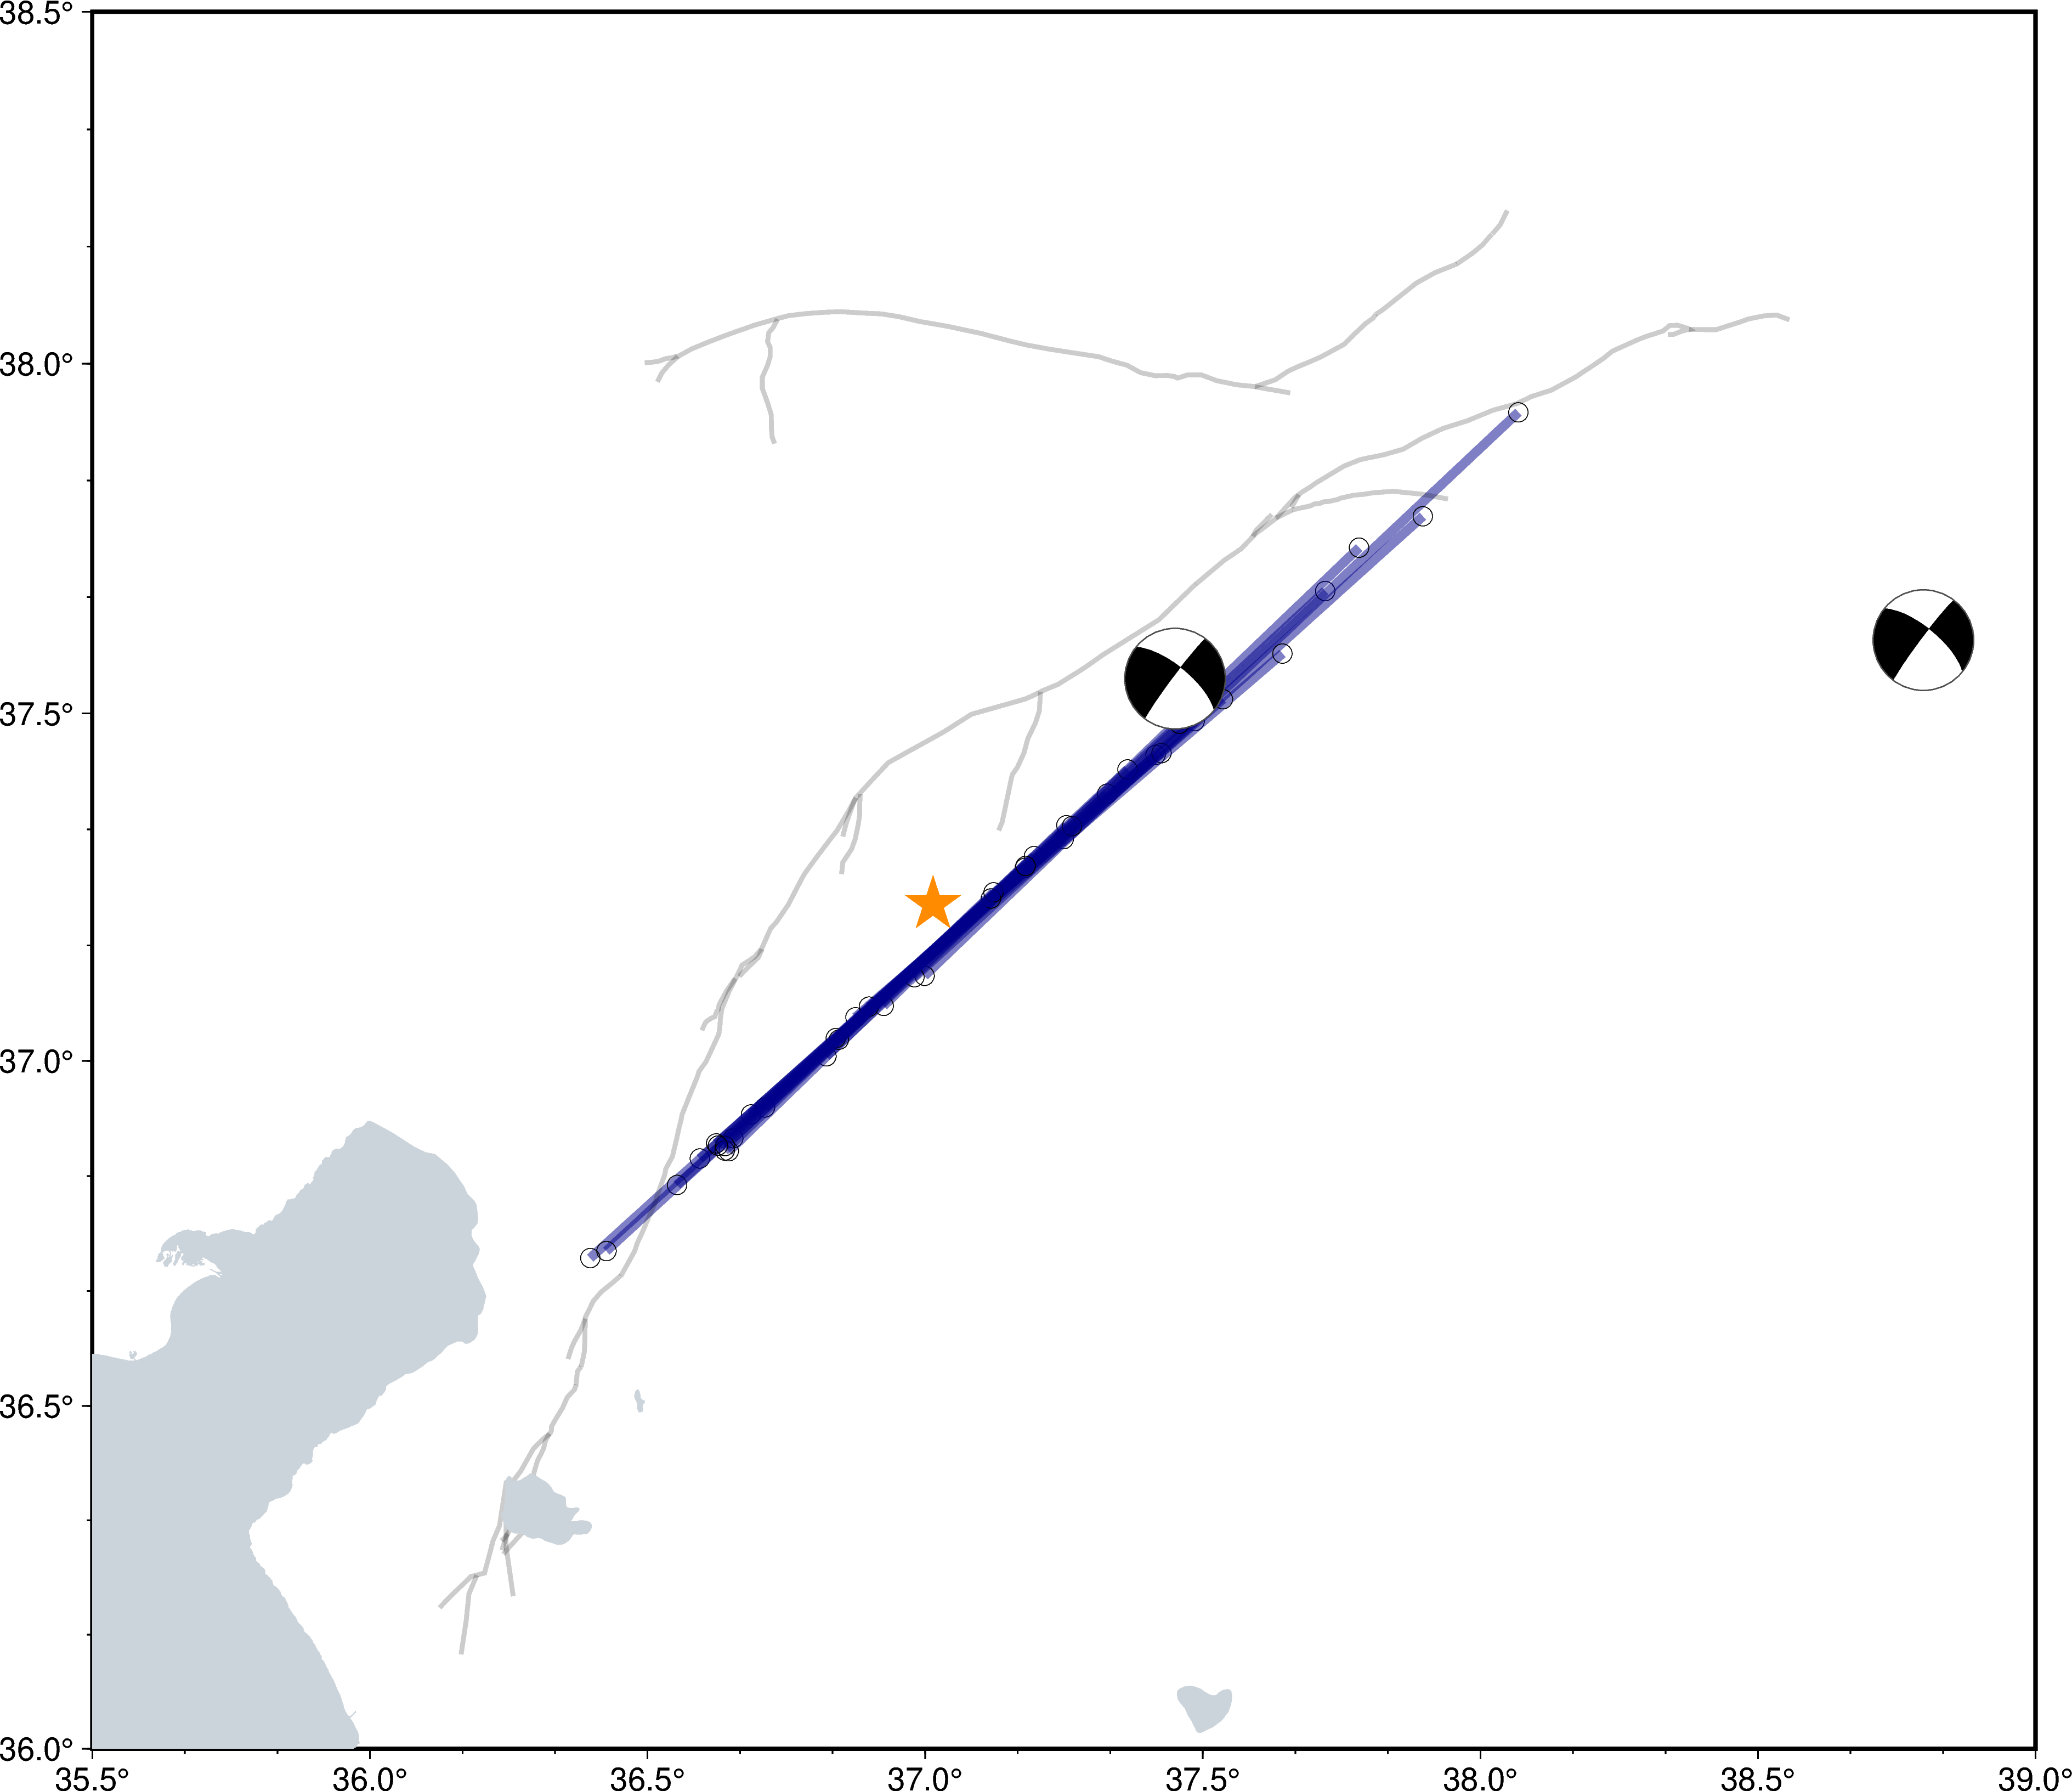

In [ ]:
pwd = os.getcwd()

# Initialize figure
fig = pygmt.Figure()
# Set PyGMT universal configurations
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain", FONT="14p")
projection = 'M0/0/30c'
rgn = [35.5, 39, 36, 38.5]

fig.basemap(region=rgn, projection=projection, frame=True)

## Plot Fault ruptures (iterate over each fault)
for index, row in df.iterrows():
  p1 = [row['lons'][0],row['lats'][0]]
  p2 = [row['lons'][1],row['lats'][1]]
  # p3 = row['lons'][2]
  # p4 = row['lons'][3]
  fig.plot(x=[p1[0], p2[0]], y=[p1[1], p2[1]], pen='4p,darkblue'  transparency=50, label=f"Fault Realizations +S.5c", region=rgn  projection=projection)
  fig.plot(x=[p1[0], p2[0]], y=[p1[1], p2[1]], style="c0.3c", pen="black")

## USGS CMT
# Pass the focal mechanism data through the spec parameter. In addition provide
# scale, event location, and event depth
fig.meca(
    spec=focal_mechanism,
    scale="1c",  # in centimeters
    longitude=float(cmt_dict['derived-longitude']),
    latitude=float(cmt_dict['derived-latitude']),
    depth=float(cmt_depth),
    pen="0.5p,gray30,solid",
)

## GCMT Solution
# https://www.globalcmt.org/cgi-bin/globalcmt-cgi-bin/CMT5/form?itype=ymd&yr=2023&mo=2&day=5&oyr=2023&omo=3&oday=1&jyr=1976&jday=1&ojyr=1976&ojday=1&otype=nd&nday=4&lmw=0&umw=10&lms=0&ums=10&lmb=0&umb=10&llat=-90&ulat=90&llon=-180&ulon=180&lhd=0&uhd=1000&lts=-9999&uts=9999&lpe1=0&upe1=90&lpe2=0&upe2=90&list=0
# strike1, dip1, rake1,
# strike2, dip2, rake2,
# mantissa, exponent

#  Date: 2023/ 2/ 6   Centroid Time:  1:18:10.8 GMT
#   Lat=  37.55  Lon=  37.45
#   Depth= 15.1   Half duration=18.6
#   Centroid time minus hypocenter time: 36.5
#   Moment Tensor: Expo=27  -0.371 -5.110 5.480 -1.410 1.350 1.300 
#   Mw = 7.8    mb = 0.0    Ms = 7.8   Scalar Moment = 5.8e+27
#   Fault plane:  strike=51    dip=70   slip=-4
#   Fault plane:  strike=143    dip=86   slip=-160

focal_mechanism = {"strike1": -51, "dip1": 70, "rake1": -4, "strike2": -143, "dip2": 86, "rake2":-160, "mantissa":5.8, "exponent": 27}

fig.meca(
    spec=focal_mechanism,
    scale="1c",  # in centimeters
    longitude=37.45,
    latitude=37.55,
    depth=15.1,
    pen="0.5p,gray30,solid",
)

# Plot hypocenter
fig.plot(x=37.0143, y = 37.2256, style="a0.9c", fill="darkorange", label="M7.8 Hypocenter")

# USGS Fault rupture
file = '/Users/hyin/usgs_mendenhall/2023_turkey_pathways/map-layers/map_layers/Turkey_Emergency_EQ_Data/simple_fault_2023-03-15/simple_fault_2023-3-15.shp'
fig.plot(data=file, pen='2p,black', transparency=80, label=f"Surface rupture (USGS)+S.5c", region=rgn, projection=projection)

fig.coast(shorelines=False, region=rgn, projection=projection, water='204/212/219')

fig.show()
fig.savefig(pwd+'/outputs/ruptures.png')


## Plot Hypocenter vs CMT location

## Plot aftershocks

## FROM CHanel

from libcomcat.search import search
from libcomcat.dataframes import get_detail_data_frame
from libcomcat.dataframes import get_summary_data_frame
import pandas as pd

if len(events) > 0:
    print("Returned %s events" % len(events))
    print("Downloading event details.")
    rows = []
    for event in events:
        row = {"id:": event.id}
        summary = event.toDict()
        if not event.hasProduct("moment-tensor"):
            rows.append(summary)
            continue
        row.update(summary)
        detail = event.getDetailEvent()
        tensor = detail.getProducts("moment-tensor", source="preferred")[0]
        row.update(tensor._product["properties"])
        # for key in tensor.properties:
        #     row[key] = tensor[key]
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(args.outfile, index=False)
else:
    print('0 events were returned for your search')